In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set()

In [2]:

def readAtomicTimes(file_path):
    names=['name', 'blocks','threads','iterations','size','validated','time']
    df = pd.read_csv(file_path, names=names)
    df['name'] = (df['name'].str
                             .replace('add_as_accumuluated_requests', 'aggregated')
                            .replace('add_as_requests', 'requests')
                            .replace('add_trival', 'trivial'))
    df['total_threads'] = df['threads'] * df['blocks']
    df['throughput'] = df['iterations'] * df['total_threads'] / df['time']
    return df

def plotAtomics(df, x):
    palette=['#D98880', '#58D68D', '#A569BD', '#A93226', '#28B463', '#6C3483']
    plot = sns.lineplot(data=df, x=x, y='throughput', palette=palette, marker="o",
                        hue=df[['name', 'size']].apply(lambda x: (x['name'] + '-' + str(x['size'])), axis=1))
    plot.set_xscale('log', base=2)
    
    plot.set(yscale='log')
    sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
    
def plotQueues(df, x):
    plot = sns.lineplot(data=df, x=x, y='throughput', marker="o",hue='name')
    plot.set_xscale('log', base=2)
    
    plot.set(yscale='log')
    sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))


def readQueuTimes(file_path):
    names=['platform', 'name','threads','blocks','iterations','time']
    df = pd.read_csv(file_path, names=names)
    df['total_threads'] = df['threads'] * df['blocks']
    df['throughput'] = df['iterations'] * df['total_threads'] / df['time']
    return df





def readHashMapTimes(file_path):
    names=['name', 'load', 'block_size', 'keycount', 'true_load', 'insert_ms', 'find_ms', 'insert_qps', 'find_qps', 'insert_GBps', 'find_GBps']
    df = pd.read_csv(file_path, names=names, delimiter=' ')
    return df

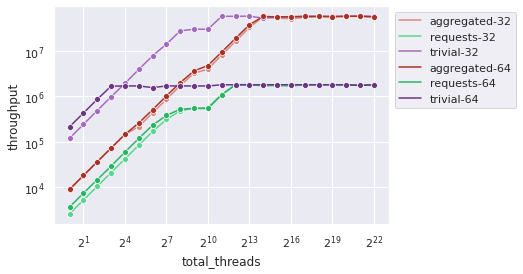

In [3]:
atomicadd1 = readAtomicTimes("../results/atomicadd_singleblock.txt")
atomicadd2 = readAtomicTimes("../results/atomicadd.txt")
atomicadd2 = atomicadd2[(atomicadd2["threads"]==1024)]
atomicadd = atomicadd1.append(atomicadd2, ignore_index=True)
plotAtomics(atomicadd, x='total_threads')

In [4]:
#
# more_block =atomicadd[(atomicadd["threads"]==512)]
# plotAtomics(more_block, x='blocks')

In [5]:
# more_block =atomicadd[(atomicadd["threads"]==256)]
# plotAtomics(more_block, x='blocks')

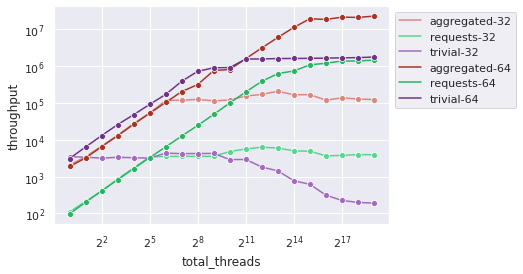

In [6]:
atomiccas_oneblock = readAtomicTimes("../results/atomiccas_singleblock.txt")
atomiccas = readAtomicTimes("../results/atomiccas.txt")
atomiccas = atomiccas_oneblock.append(atomiccas, ignore_index=True)
plotAtomics(atomiccas, x='total_threads')

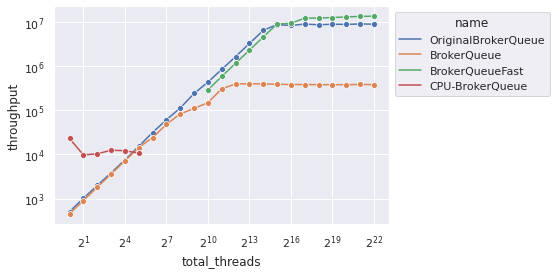

In [7]:
queue_times = readQueuTimes("../results/queues.txt")
cpu_queue_times = readQueuTimes("../results/cpu_queues.txt")
cpu_queue_times['name'] = (cpu_queue_times['name'].str
                             .replace('BrokerQueue', 'CPU-BrokerQueue'))

queue_times = queue_times.append(cpu_queue_times, ignore_index=True)
plotQueues(queue_times, 'total_threads')

In [27]:
hash_times = readHashMapTimes('../results/hash_maps_contigous_keyval_loayout.txt')
def plotHashInsert(df, x, y, logxscale=True):
    plot = sns.lineplot(data=df, x=x, y=y, marker="o",
                        hue=df[['useBuckets', 'probing']].apply(lambda x: (x['probing'] + '-Buckets:' + str(x['useBuckets'])), axis=1))
    
    if logxscale:
        plot.set_xscale('log', base=2)
    
    plot.set(yscale='log')
    sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
    return plot

def plotHashInsertTheir(df, x, y, logxscale=True, ax=None):
    plot = sns.lineplot(data=df, x=x, y=y, marker="o", ax=ax,
                        hue='name')
    
def name_to_properties(name):
    name, prob, usebucket, groupsize, vecread = name.split('|')
    usebucket = usebucket.split(':')[1] == '1'
    groupsize = int(groupsize.split(':')[1])
    vecread = int(vecread.split(':')[1])
    return prob, usebucket, groupsize, vecread

my_times = hash_times[~hash_times['name'].isin(['DycuckooHashTableWrapper', 'WarpCore'])]
their_times = hash_times[hash_times['name'].isin(['DycuckooHashTableWrapper', 'WarpCore'])]
my_times['probing'], my_times['useBuckets'], my_times['groupsize'], my_times['vecread'] = zip(
    *my_times['name'].map(name_to_properties))



/tmp/ipykernel_6488/526177496.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_times['probing'], my_times['useBuckets'], my_times['groupsize'], my_times['vecread'] = zip(


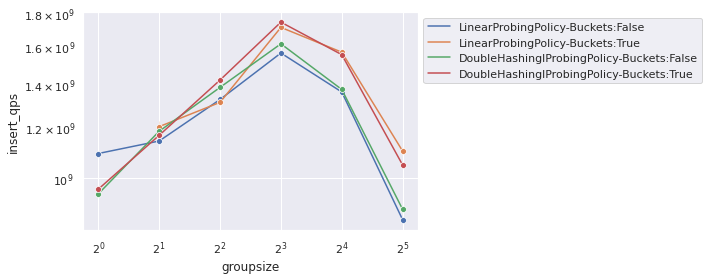

In [9]:
density = 0.80
dens80 = my_times[my_times['load'] == density ]
plotHashInsert(dens80, 'groupsize','insert_qps')

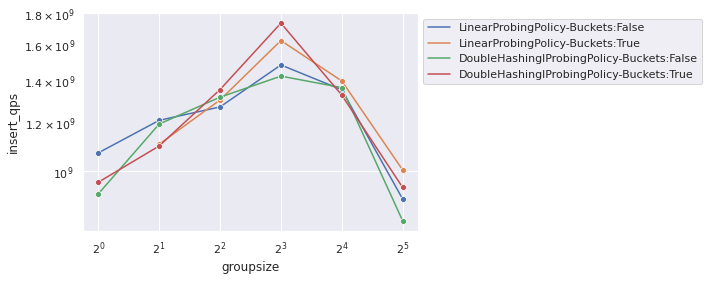

In [17]:
density = 0.80
dens80 = my_times[my_times['load'] == density ]
plotHashInsert(dens80, 'groupsize','insert_qps')

<AxesSubplot:xlabel='load', ylabel='insert_qps'>

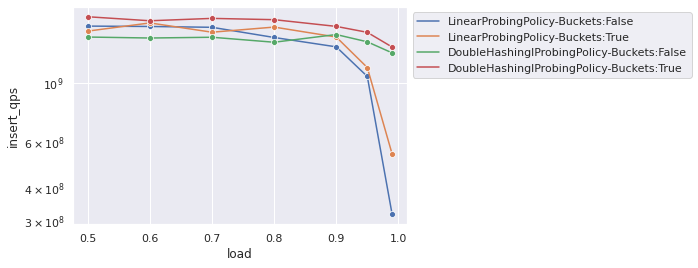

In [35]:
plotHashInsert(my_times[my_times['groupsize'] == 8 ], 'load', 'insert_qps', False)


<AxesSubplot:xlabel='load', ylabel='insert_qps'>

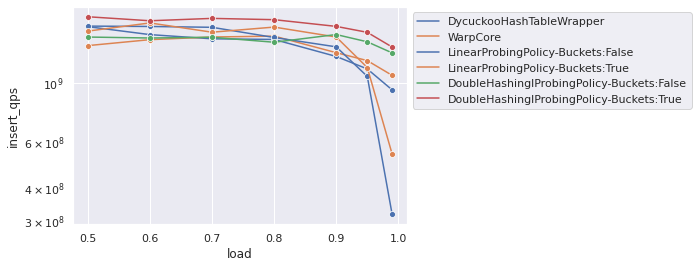

In [36]:
plotHashInsertTheir(their_times, 'load', 'insert_qps', logxscale=False, ax=None)
plotHashInsert(my_times[my_times['groupsize'] == 8 ], 'load', 'insert_qps', False)


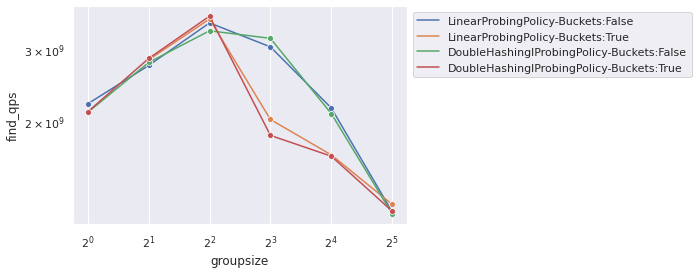

In [13]:
density = 0.60
dens80 = my_times[my_times['load'] == density ]
plotHashInsert(dens80, 'groupsize', 'find_qps')

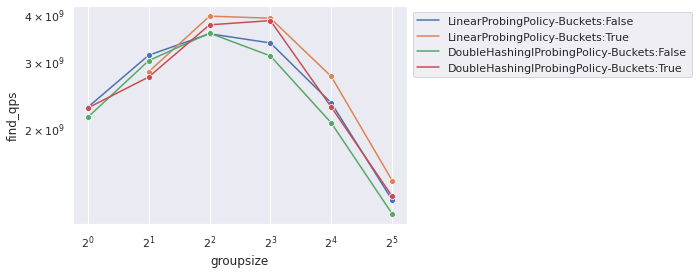

In [19]:
density = 0.60
dens80 = my_times[my_times['load'] == density ]
plotHashInsert(dens80, 'groupsize', 'find_qps')

<AxesSubplot:xlabel='load', ylabel='insert_qps'>

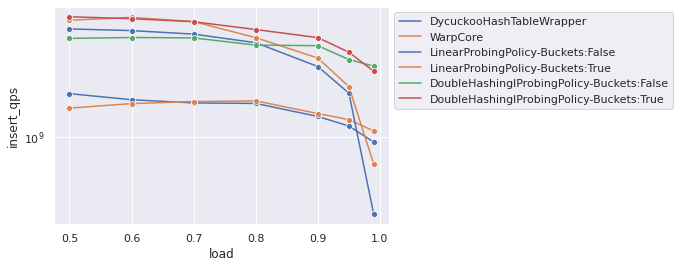

In [34]:
plotHashInsertTheir(their_times, 'load', 'insert_qps', False)
plotHashInsert(my_times[my_times['groupsize'] == 8 ], 'load', 'find_qps', False)